# Dueling Deep Q-Learning

> Dueling Deep Q-Networks (Dueling DQN) is an extension of the Deep Q-Learning (DQN) algorithm designed to improve the learning efficiency and stability of value-based reinforcement learning agents. __The key idea behind Dueling DQN is to separate the estimation of the state value function and the advantage function, allowing the agent to better understand the value of being in a certain state and the advantage of taking a particular action within that state.__


__Basic Q-Value Decomposition:__
- In the standard Q-learning setting, the Q-value for a state-action pair $(s,a)$ is represented by $Q(s,a)$. This value can be decomposed into the sum of two components:
  - $Q(s,a) = V(s) + A(s,a)$
    - $V(s)$: The state value function represents the value of being in a particular state $s$ __irrespective of the action taken__. It reflects __how good it is to be in that state on average__.
    - $ A(s,a)$: The advantage function represents the additional value of taking a particular action $a$ in state $s$ compared to the average value of all actions in that state. It captures the benefit of selecting a specific action.

__Dueling DQN Architecture:__

Dueling DQN introduces a neural network architecture that explicitly models these separate components, allowing the network to estimate both the state value and the advantage for each action. The dueling architecture consists of two streams:

1. __Value stream ($V(s)$):__
  - This stream estimates the state value $V(s)$ and has a single output node.
2. __Advantage  stream ($V(s,a)$):__
  - This stream estimates the advantage of each action $(A(s,a))$ and has as many output nodes as there are possible actions.



__The final Q-value is obtained by combining the value and advantage streams:__


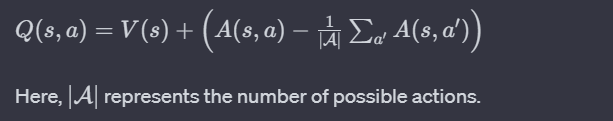

In [ ]:
!apt-get install -y xvfb

!pip install pygame pytorch-lightning==1.6.0 pyvirtualdisplay

# for the environment
!pip install git+https://github.com/GrupoTuring/PyGame-Learning-Environment
!pip install git+https://github.com/lusob/gym-ple

#### Setup virtual display

In [ ]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

#### Import the necessary code libraries

In [ ]:
import copy
import torch
import random
import gym
import gym_ple
import matplotlib

import numpy as np
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning import LightningModule, Trainer

from gym.wrappers import TransformObservation

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

In [ ]:
# Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb#scrollTo=gKc1FNhKiVJX

def display_video(frames, framerate=30):
  """
  Return a HTML video format.
  """
  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/framerate
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  return HTML(anim.to_html5_video())

#### Create the Deep Q-Network

In [ ]:

class DQN(nn.Module):
    def __init__(self, hidden_size, obs_size, n_actions):
        super().__init__()

        # Shared feature extraction network
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        """
        Decompose the Q(s,a) into two parts:
        1. The value of the state itself (fc_value).
          - this is the value of the state itself. (what is the avarage
            value if I'm in that state?).
          -
        2. The advantage of an action is that state (fc_adv).
          - Is the value of a specific action in that state!
            (its tell us if a specific action in that state is better than the
             avarage value of taking an action in that state.)
             "there is some advantage to take this action in that state..?"
        """
        # 1. Value stream
        # - how good it is for an agent to be in that state?
        # - how big is the return that we expect to obtain if we follow our
        #   policy starting in this state?
        # --> Input: Features
        # --> Output: V(s)
        self.fc_value = nn.Linear(hidden_size, 1)

        # 2. Advantage stream
        # - how much better or worse it is to take a specific action
        #   in that state over the value of that state.
        # --> Input: Features
        # --> Output: [Q(s,a),Q(s,a),...] as the number of actions.
        self.fc_adv = nn.Linear(hidden_size, n_actions)

    def forward(self, x):
        x = self.net(x.float())   # Feature extraction - Pass the state for extraxt patterns
        value = self.fc_value(x)  # Estimate Value stream V(s)
        adv = self.fc_adv(x)      # Estimate Advantage stream [Q(s1,a1),Q(s1,a2),...]

        # Combine value and advantage streams using dueling formula
        q_values = value + adv - torch.mean(adv, dim=1, keepdim=True)

        return q_values

#### Create the policy

In [ ]:
def epsilon_greedy(state, env, net, epsilon=0.0):
  """
  Epsilon greedy policy. balance exploration and exploitation.
  """
  if np.random.random() < epsilon:
    action = env.action_space.sample()
  else:
    state = torch.tensor([state]).to(device)
    q_values = net(state)
    _, action = torch.max(q_values, dim=1)
    action = int(action.item())
  return action

#### Create the replay buffer

In [ ]:
class ReplayBuffer:

  def __init__(self, capacity):
    self.buffer = deque(maxlen=capacity)

  def __len__(self):
    return len(self.buffer)

  def append(self, experience):
    self.buffer.append(experience)

  def sample(self, batch_size):
    return random.sample(self.buffer, batch_size)

In [ ]:
class RLDataset(IterableDataset):

  def __init__(self, buffer, sample_size=400):
    self.buffer = buffer
    self.sample_size = sample_size

  def __iter__(self):
    for experience in self.buffer.sample(self.sample_size):
      yield experience

#### Create the environment

In [ ]:
class RunningMeanStd:
  """
  Class for computing the running mean and std, for keep normalize
  the observations and rewards in real time.

  Normalize the observation & rewards produce better and stable results,
  especially use un neural networks.
  """
    # https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, "float64")
        self.var = np.ones(shape, "float64")
        self.count = epsilon

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        self.mean, self.var, self.count = update_mean_var_count_from_moments(
            self.mean, self.var, self.count, batch_mean, batch_var, batch_count
        )


def update_mean_var_count_from_moments(
    mean, var, count, batch_mean, batch_var, batch_count
):
    delta = batch_mean - mean
    tot_count = count + batch_count

    new_mean = mean + delta * batch_count / tot_count
    m_a = var * count
    m_b = batch_var * batch_count
    M2 = m_a + m_b + np.square(delta) * count * batch_count / tot_count
    new_var = M2 / tot_count
    new_count = tot_count

    return new_mean, new_var, new_count


class NormalizeObservation(gym.core.Wrapper):
  """
  Normalize the observations
  """
    def __init__(
        self,
        env,
        epsilon=1e-8,
    ):
        super().__init__(env)
        self.num_envs = getattr(env, "num_envs", 1)
        self.is_vector_env = getattr(env, "is_vector_env", False)
        if self.is_vector_env:
            self.obs_rms = RunningMeanStd(shape=self.single_observation_space.shape)
        else:
            self.obs_rms = RunningMeanStd(shape=self.observation_space.shape)
        self.epsilon = epsilon

    def step(self, action):
        obs, rews, dones, infos = self.env.step(action)
        if self.is_vector_env:
            obs = self.normalize(obs)
        else:
            obs = self.normalize(np.array([obs]))[0]
        return obs, rews, dones, infos

    def reset(self, **kwargs):
        return_info = kwargs.get("return_info", False)
        if return_info:
            obs, info = self.env.reset(**kwargs)
        else:
            obs = self.env.reset(**kwargs)
        if self.is_vector_env:
            obs = self.normalize(obs)
        else:
            obs = self.normalize(np.array([obs]))[0]
        if not return_info:
            return obs
        else:
            return obs, info

    def normalize(self, obs):
        self.obs_rms.update(obs)
        return (obs - self.obs_rms.mean) / np.sqrt(self.obs_rms.var + self.epsilon)


class NormalizeReward(gym.core.Wrapper):
  """
  Normalize the rewards
  """
    def __init__(
        self,
        env,
        gamma=0.99,
        epsilon=1e-8,
    ):
        super().__init__(env)
        self.num_envs = getattr(env, "num_envs", 1)
        self.is_vector_env = getattr(env, "is_vector_env", False)
        self.return_rms = RunningMeanStd(shape=())
        self.returns = np.zeros(self.num_envs)
        self.gamma = gamma
        self.epsilon = epsilon

    def step(self, action):
        obs, rews, dones, infos = self.env.step(action)
        if not self.is_vector_env:
            rews = np.array([rews])
        self.returns = self.returns * self.gamma + rews
        rews = self.normalize(rews)
        self.returns[dones] = 0.0
        if not self.is_vector_env:
            rews = rews[0]
        return obs, rews, dones, infos

    def normalize(self, rews):
        self.return_rms.update(self.returns)
        return rews / np.sqrt(self.return_rms.var + self.epsilon)

In [ ]:
env = gym_ple.make("FlappyBird-v0")

In [ ]:
env.reset()
env.unwrapped.game_state.getGameState()

In [ ]:
list(env.unwrapped.game_state.getGameState().values())

In [ ]:
env.unwrapped.game_state.frame_skip = 4

In [ ]:
class StateVectorWrapper(gym.Wrapper):
  """
  Convert image observation (state) of the environment to a state vector of numbers.
  """

  def __init__(self, env):
    super().__init__(env)
    # get initial state
    state = self.reset()
    # create the observation space objects
    self.observation_space = gym.spaces.Box(
        # action space go from [-inf,inf]
        low=float('-inf'),
        high=float('inf'),
        # set the shape
        shape=state.shape
    )

  def reset(self):
    """
    Define what happens when we reset the environment
    """
    # reset
    super().reset()
    # take the state dictionary
    state_dict = self.env.unwrapped.game_state.getGameState()
    # extract the values only (vector of numbers)
    state = list(state_dict.values())
    # return state as numpy array (vector of numbers that represent the state)
    return np.array(state)

  def step(self, action):
    """
    Define how to modify the observation when we take a step in the env
    """
    # Perform the action
    _, reward, done, info = super().step(action)
    # return the observation, rewards, and so on (transition)
    next_state_dict = self.env.unwrapped.game_state.getGameState()
    next_state = list(next_state_dict.values())
    return np.array(next_state), reward, done, info

In [ ]:
def create_environment(name):
  """
  Create an environment and apply the transformation that we need.
  """
  env = gym_ple.make(name) # create env
  env = StateVectorWrapper(env) # Make sure the state'll return as vector
  env = NormalizeObservation(env) # Normalize the observations
  env = NormalizeReward(env) # Normalize the rewards.
  return env

In [ ]:
env = create_environment('FlappyBird-v0')
frames = []

for episode in range(10):
  done = False
  env.reset()
  while not done:
    frames.append(env.render(mode='rgb_array'))
    action = env.action_space.sample()
    _, _, done, _ = env.step(action)

In [ ]:
display_video(frames)

#### Create the Deep Q-Learning algorithm

In [ ]:
class DeepQLearning(LightningModule):
  """
  Implementing the Dueling Deep Q-learning

  Parameters
  -----------
  - `env_name`: the name of the environment
  - `policy`: the policy (typically epsilon greedy)
  - `capacity`: size of memory
  - `batch_size`: batch size
  - `lr`: learning rate
  - `hidden_size`: number of hidden layers
  - `gamma`: discount factor for computing the expected return
  - `loss_fn`: loss function
  - `optim`: optimizer
  - `eps_start`: initial epsilon
  - `eps_end`: end value epsilon
  - `eps_last_episode`: last episode of updating the epsilon
  - `samples_per_epoch`: number of sample of generate per epoch (for pass new experiences to the memory)
  - `sync_rate`: each number of time to update the target ANNs.
  """

  # Initialize.
  def __init__(self, env_name, policy=epsilon_greedy, capacity=100_000,
               batch_size=256, lr=1e-3, hidden_size=128, gamma=0.99,
               loss_fn=F.smooth_l1_loss, optim=AdamW, eps_start=1.0, eps_end=0.15,
               eps_last_episode=100, samples_per_epoch=1_000, sync_rate=10):

    super().__init__()
    self.env = create_environment(env_name) # create environment

    obs_size = self.env.observation_space.shape[0] # Input shape: state
    n_actions = self.env.action_space.n # Output shape: actions

    # Create the Q-network
    self.q_net = DQN(hidden_size, obs_size, n_actions)
    # Create the Target-Q-network
    self.target_q_net = copy.deepcopy(self.q_net)
    # Define the policy
    self.policy = policy
    # Define the memory
    self.buffer = ReplayBuffer(capacity=capacity)

    self.save_hyperparameters()

    # ...Generate transitions (experieces) and pass them to the memory...
    while len(self.buffer) < self.hparams.samples_per_epoch:
      print(f"{len(self.buffer)} samples in experience buffer. Filling...")
      self.play_episode(epsilon=self.hparams.eps_start)

  @torch.no_grad()
  def play_episode(self, policy=None, epsilon=0.):
    """
    Play one epicode.

    Use for generate more and newer experiences for add more experiences
    and refresh the memoey with new transitions..
    """
    state = self.env.reset()
    done = False

    while not done:
      if policy:
        action = policy(state, self.env, self.q_net, epsilon=epsilon)
      else:
        action = self.env.action_space.sample()
      next_state, reward, done, info = self.env.step(action)
      exp = (state, action, reward, done, next_state)
      self.buffer.append(exp)
      state = next_state

  # Forward.
  def forward(self, x):
    """
    Forward propegate.

    Return the Q values ([[Q(s,a)],[Q(s,a)],[Q(s,a)],...])
    """
    return self.q_net(x)

  # Configure optimizers.
  def configure_optimizers(self):
    q_net_optimizer = self.hparams.optim(self.q_net.parameters(), lr=self.hparams.lr)
    return [q_net_optimizer]

  # Create dataloader.
  def train_dataloader(self):
    dataset = RLDataset(self.buffer, self.hparams.samples_per_epoch)
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=self.hparams.batch_size
    )
    return dataloader

  # Training step.
  def training_step(self, batch, batch_idx):

    # 1. Unpack the batch and reshape it:
    # [[s],[s],[s]..]
    # [[a],[a],[a]..]
    # ...
    # [[s'],[s'],[s']..]
    states, actions, rewards, dones, next_states = batch
    actions = actions.unsqueeze(1)
    rewards = rewards.unsqueeze(1)
    dones = dones.unsqueeze(1)

    # 2. Given current states and actions, compute Q(s,a)
    # will return [Q(s,a),Q(s,a),Q(s,a),....]
    state_action_values = self.q_net(states).gather(1, actions)

    # 3. Update the Q-netwoek using the target.
    with torch.no_grad():
      # For the NEXT states, predict by the Q-network the max Q-values
      # that came from the best actions!
      # returns the best actions to perform in the next states: [a*, a*, ...]
      _, next_actions = self.q_net(next_states).max(dim=1, keepdim=True)
      # Take the predicted best actions for the next state, and evaluate
      # the next states & best actions by the Target-Q-network.
      # it'll reutrn the values of: [Q(s',a*), Q(s',a*), ...]
      next_action_values = self.target_q_net(next_states).gather(1, next_actions)
      # Make sure that you don't calculate any extra rewards.
      next_action_values[dones] = 0.0

    # 4. Compute the expected Q(s,a) -> the target
    expected_state_action_values = rewards + self.hparams.gamma * next_action_values

    # 5. Compute the loss between the actual Q(s,a) and the target Q(s',a*).
    loss = self.hparams.loss_fn(state_action_values, expected_state_action_values)
    self.log('episode/Q-Error', loss)
    return loss

  # Training epoch end.
  def training_epoch_end(self, training_step_outputs):
    """
    Callback function where a training epoch done.
    """
    # compute the epsilon
    epsilon = max(
        self.hparams.eps_end,
        self.hparams.eps_start - self.current_epoch / self.hparams.eps_last_episode
    )

    # play an epicode for gain more experience, and pass more experiences
    # to the memory with the most resent policy.
    self.play_episode(policy=self.policy, epsilon=epsilon)
    self.log('episode/Return', self.env.unwrapped.game_state.score())

    # Update the Target-Q-network weigths every `sync_rate` epochs
    if self.current_epoch % self.hparams.sync_rate == 0:
      self.target_q_net.load_state_dict(self.q_net.state_dict())

#### Purge logs and run the visualization tool (Tensorboard)

In [ ]:
!rm -r /content/lightning_logs/
!rm -r /content/videos/
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs/

#### Train the policy

In [ ]:
algo = DeepQLearning(
  'FlappyBird-v0',
  lr=5e-4,
  hidden_size=512,
  eps_end=0.01,
  eps_last_episode=1_000,
  capacity=10_000,
  gamma=0.9
)

trainer = Trainer(
  gpus=num_gpus,
  max_epochs=3_000,
  log_every_n_steps=1
)

trainer.fit(algo)

#### Check the resulting policy

In [ ]:
env = algo.env
policy = algo.policy
q_net = algo.q_net
frames = []

for episode in range(10):
  done = False
  obs = env.reset()
  while not done:
    frames.append(env.render(mode='rgb_array'))
    action = policy(obs, env, q_net)
    obs, _, done, _ = env.step(action)

In [ ]:
display_video(frames)